# Bonds 3

This notebook presents a yield curve model (a simplified Vasicek model) and then uses it to improve upon the duration hedging approach.

## Load Packages and Extra Functions

In [1]:
using Printf 

include("jlFiles/printmat.jl");

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

# Predictions from an AR(1)

Consider an AR(1) with mean $\mu$

$r_{t+1}-\mu=\rho\left(  r_{t}-\mu\right)  +\varepsilon_{t+1}$

The forecast (based on information in $t$) for $t+s$ is

$\text{E}_{t}r_{t+s}=\left(  1-\rho^{s}\right)  \mu+\rho ^{s}r_{t}.$

In the the cells below, we code a function for these forecasts and then plot the results (for many forecasting horizons and also for several different starting values).

In [3]:
"""
    AR1Prediction(r0,ρ,μ,s)

Calculate forecast from AR(1)

r0,ρ,μ,s: scalars
"""
function AR1Prediction(r0,ρ,μ,s)
    E0xs = (1-ρ^s)*μ + ρ^s*r0
    return E0xs
end

AR1Prediction

In [4]:
(μ,ρ) = (0.05,0.975)
 
printlnPs("Prediction for t+50, assuming current r=0.07: ",AR1Prediction(0.07,ρ,μ,50))

Prediction for t+50, assuming current r=0.07:      0.056


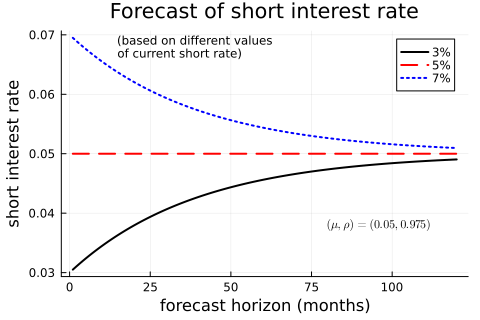

In [5]:
sMax = 120                                   #make forecasts for many horizons and initial values
s_range = 1:sMax                             #different horizons, months
r₀      = [0.03,0.05,0.07]

xPred = fill(NaN,sMax,length(r₀))          #xPred[maturity,r₀ value]
for s in s_range, j = 1:length(r₀)
    xPred[s,j] = AR1Prediction(r₀[j],ρ,μ,s)
end
#xPred = [AR1Prediction(r,ρ,μ,s) for s in s_range,r in r₀]    #alternative to the loop

txt = text(L"(\mu,\rho) = (%$μ,%$ρ)",8,:left)   #laTeX string to plot, notice %$
p1 = plot( s_range,xPred,
           linecolor = [:black :red :blue],
           linewidth = 2,
           linestyle = [:solid :dash :dot],
           label = ["3%" "5%" "7%"],
           title = "Forecast of short interest rate",
           xlabel = "forecast horizon (months)",
           ylabel = "short interest rate",
           annotation = [(80,0.038,txt),
                    (15,0.068,text("(based on different values\nof current short rate)",8,:left))] )
display(p1)

# The Vasicek Model

The simpified (because of no risk premia) Vasicek model implies that

$
y_{t}(n) =a(n)+b(n)r_{t} \: \textrm{, where }
$

$
b(n)     =(1-\rho^{n})/[(1-\rho)n],
$

$
a(n)     = \mu\left[  1-b(n)\right].
$

In the example, we think of the periods as months but the scale of the interest rate level is annualised (as is traditional). For instance, $y_{t}(36)$ which corresponds to `y[36]` in the code, is the (annualized) continuously compounded interest rate for a bond maturing in 36 months (3 years).

In the cells below, we code a function for this model and then plots the results for many different maturities (horizons) and several initial values of the short interest rate.

### A Remark on the Code

The code (used below)

```
if j == 1
    ab[n,:] = [a b]
end
```
could also have been written on a single line

```(j==1) && (ab[n,:] = [a b])```

In [6]:
"""
    Vasicek(r,ρ,μ,n)

Vasicek model: calculate interest rate and (a,b) coeffs
r,ρ,μ,n: scalars

n is the maturity, but this could be measured in any unit (months, years, etc), 
but changing the units require recalibrating ρ
"""
function Vasicek(r,ρ,μ,n)
    if ρ == 1.0
        b = 1.0
    else
        b = (1-ρ^n)/((1-ρ)*n)
    end
    a = μ*(1-b)
    y = a + b*r
    return y,a,b
end

Vasicek

In [7]:
y = fill(NaN,sMax,length(r₀))         #interest rates, different starting values in columns
ab = fill(NaN,sMax,2)                 #a and b coefs 
for n in s_range, j = 1:length(r₀)
    #local a, b                      #local/global is needed in script
    (y[n,j],a,b) = Vasicek(r₀[j],ρ,μ,n)
    if j == 1
        ab[n,:] = [a b]                 #update ony if j==1, the same across r₀ values
    end
end

printblue("a and b for the first few horizons (months):")
printmat([ab[1:4,1]*100 ab[1:4,2]],colNames=["a*100","b"],rowNames=string.(s_range[1:4]),cell00="horizon")

a and b for the first few horizons (months):
horizon     a*100         b
1           0.000     1.000
2           0.062     0.988
3           0.124     0.975
4           0.184     0.963



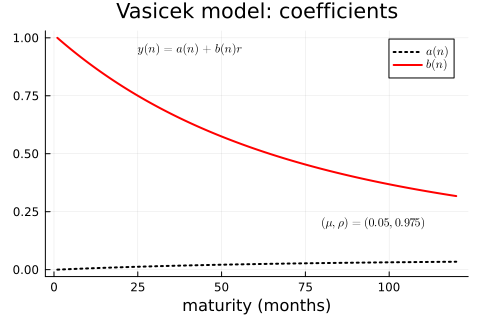

In [8]:
p1 = plot( s_range,ab,
           linecolor = [:black :red],
           linestyle = [:dot :solid],
           linewidth = 2,
           label = [L"a(n)" L"b(n)"],
           title = "Vasicek model: coefficients",
           xlabel = "maturity (months)",
           annotation = [(80,0.2,txt),
                    (25,0.95,text(L"y(n) = a(n) + b(n)r",8,:left))] )
display(p1)

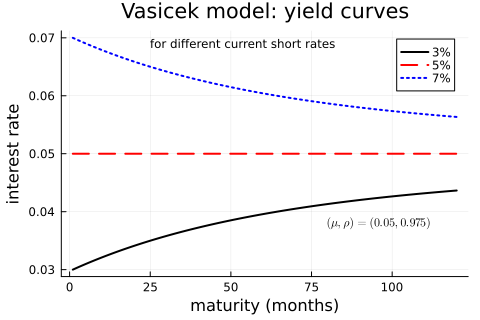

In [9]:
p1 = plot( s_range,y,
           linecolor = [:black :red :blue],
           linewidth = 2,
           linestyle = [:solid :dash :dot],
           label = ["3%" "5%" "7%"],
           title = "Vasicek model: yield curves",
           xlabel = "maturity (months)",
           ylabel = "interest rate",
           annotation = [(80,0.038,txt),
                    (25,0.069,text("for different current short rates",8,:left))] )
display(p1)

# Hedging Using the Vasicek Model

The change of the (value of the) hedge portfolio is 

$
\Delta V=v\Delta P_{H}-\Delta P_{L}
$


A. For an initial value of the short log interest rate $r$, use the Vasicek model to calculate all spot rates needed to discount the cash flows of the two bond portfolios. Repeat for a somewhat different short rate. 

B. Calculate the prices of both the liability $P_L$ and the hedge bond $P_H$, at both interest rates and define the change ($\Delta P_{L}$ and $\Delta P_{H}$).

C. Calculate the $v$ value that makes $\Delta V = 0$, that is, $v=\Delta P_{L}/\Delta P_{H}$.

## Bond Pricing Functions

The next cell codes up functions for price of a zero coupon bond and a bond portfolio, based on continously compounded interest rates.

In [10]:
"""
    BillPrice2(y,m)

Zero coupon bond price as a function of (y,m). m is typically measured in terms of years.
"""
BillPrice2(y,m) = exp(-m*y)


"""
    BondPrice3b(y,cf,m)

Calculate bond price from continously compounded interest rates, cash flows and time to cash flow.

y:  scalar or K vector of continuously compounded interest rates
cf: K vector of cash flows
m:  K vector of times (years) of cash flows
"""
function BondPrice3b(y,cf,m)                #cf is a vector of all cash flows
    (length(cf) != length(m)) && error("BondPrice3b: cf and m must have the same lengths")    
    cdisc = cf./exp.(m.*y)
    P     = sum(cdisc)                      #price
    return P
end

BondPrice3b

## Information about the Two Bonds

In the example below, the liability pays 0.2 every 12 months for 10 years. The hedge bond is a 3-year zero coupon bond.

For the liability we define the periods (months) that we will consider as `1:120`, but the cash flows as `repeat([zeros(11);0.2],10)`, which means that the cash flows are zero in most periods, but 0.2 in period 12, 24,..., 120.

In [11]:
nL  = 1:120                       #months, for the liability
nH  = 1:36                        #same, but for hedge bond

cfL = repeat([zeros(11);0.2],10)   #cash flow of liability
cfH = [zeros(35);1];               #cash flow of hedge bond, 3-year zero-coupon bond

## A. Calculate Yield Curves

at two different values of the current short rate: $r_0$ and $r_1$. This is similar to the previous figure on the Vasicek yield curves (but here for the horizons that we need in order to (later) calculate the prices of the liability and hedge bond).

In [12]:
ρ = 0.975                       #experiment with this
μ = 0.05

r₀ = 0.05                         #initial (day 0) short log interest rate
r₁ = 0.03                         #another possible short rate

nMax = maximum([nL;nH])            #calculate yield curves the maximum maturity
nM   = 1:nMax                      #time to maturity (months)

(y₀,y₁) = [fill(NaN,nMax) for i=1:2]  #yield curve, before and after
for n in nM
    y₀[n] = Vasicek(r₀,ρ,μ,n)[1]
    y₁[n] = Vasicek(r₁,ρ,μ,n)[1]
end

printred("similar to the previous figure of yield curves")

similar to the previous figure of yield curves


## B. Calculate the Prices of the Hedge Bond and the Liability

With the two yield curves (different short rate values) from the Vasicek model, calculate prices of the hedge bond and the liability. In particular, the bond price $P$ is the present value of the future cash flows $cf_k$

$P = \sum_{k=1}^{K} \frac{cf_{k}}{\exp\left[m_{k} y(m_{k})\right]  }$,

where $y(m_k)$ is the continuously compounded (annualized) interest rate on a bond maturing in $m_k$ years.

In [13]:
PL₀ = BondPrice3b(y₀[nL],cfL,nL/12)       #liability, before, /12 to get years
PL₁ = BondPrice3b(y₁[nL],cfL,nL/12)       #after 
ΔPL = PL₁ - PL₀

PH₀ = BondPrice3b(y₀[nH],cfH,nH/12)       #hedge bond
PH₁ = BondPrice3b(y₁[nH],cfH,nH/12)
ΔPH = PH₁ - PH₀

printblue("Bond prices (according to the Vasicek model) at different r values")
xy = [PL₀ PH₀;PL₁ PH₁;(PL₁-PL₀) (PH₁-PH₀)]
printmat(xy,colNames=["PL","PH"],rowNames=["at $r₀","at $r₁","Δ"])

Bond prices (according to the Vasicek model) at different r values
               PL        PH
at 0.05     1.535     0.861
at 0.03     1.609     0.896
Δ           0.074     0.035



## C. Calculate the Hedge Ratio

The overall portfolio is

$
V=vP_{H}+M-P_{L}.
$

We calculate the hedge ratio ($v$) as

$
v = \Delta P_L / \Delta P_H.
$

This should (approximately) hedge against changes in the yield curve. That is, against such changes that can be accounted for by the Vasicek model. The value of $v P_H/ P_L$ (at the old interest rates) show the value invested into the hedge bond relative to the value of the liability.

In [14]:
v = ΔPL/ΔPH                              #change PL/change PH

printblue("Hedge ratio from the Vasicek model:")
xy = [v;v*PH₀/PL₀]
printmat(xy,rowNames=["v","v*PH₀/PL₀"])

printred("Notice: ρ is important for the hedge ratio v. Try also ρ=1 to see how it changes")

Hedge ratio from the Vasicek model:
v             2.106
v*PH₀/PL₀     1.181

Notice: ρ is important for the hedge ratio v. Try also ρ=1 to see how it changes
